# Init

In [15]:
import os 
import sys


# Get the path of the current directory
path = os.path.dirname(os.getcwd())

# Go to the parent directory
path = os.path.dirname(path)

#sys.path.append(path)


import igl
#import meshplot as mp
import polyscope as ps
import vedo as vd
import numpy as np
import time 
import os
import matplotlib.pyplot as plt
from geometry.mesh import Mesh
from geometry.utils import *
from optimization.Torsal import Torsal
from optimization.Torsal_angle import Torsal_angle
from optimization.Optimizer import Optimizer
from optimization.LineCong import LineCong
from optimization.Sphere_angle import Sphere_angle

# Define paths
dir_path = path+"/hanan/"
data_path = dir_path+"/approximation/data/" # data path
out_path = dir_path+"/approximation/outputs/" # output path
math_path = dir_path+"/approximation/mathematica/" # mathematica path

In [16]:
print(data_path)

/home/anthony/Hanan Lab/hananLab/approximation/data/


In [11]:
def add_cross_field(mesh, name, vec1, vec2, rad, size, col):
    mesh.add_vector_quantity(name+"_vec1" ,    vec1, defined_on ='faces', enabled=True, radius=rad, length=size, color=col)
    mesh.add_vector_quantity(name+"_-vec1",   -vec1, defined_on ='faces', enabled=True, radius=rad, length=size, color=col)
    mesh.add_vector_quantity(name+"_vec2" ,    vec2, defined_on ='faces', enabled=True, radius=rad, length=size, color=col)
    mesh.add_vector_quantity(name+"_-vec2",   -vec2, defined_on ='faces', enabled=True, radius=rad, length=size, color=col)

def solve_torsal(vi, vj, vk, ei, ej, ek) :

    # Get edges
    vij = vj - vi 
    vik = vk - vi

    eij = ej - ei 
    eik = ek - ei
    

    ec = (ei + ej + ek)/3

    vijxec = np.cross(vij, ec)
    vikxec = np.cross(vik, ec)

    # g0 
    g0 = np.sum(eij*vijxec, axis=1)

    # g1
    g1 = np.sum(eij*vikxec, axis=1) + np.sum(eik*vijxec, axis=1)

    # g2
    g2 = np.sum(eik*vikxec, axis=1)


    disc = g1**2 - 4*g0*g2 

    t1 = np.zeros_like(vij)
    t2 = np.zeros_like(vij)

    a1 = np.zeros(len(vij))
    a2 = np.zeros(len(vij))
    b1 = np.zeros(len(vij))

    # indices disc >0 
    idx = np.where(disc > 0)[0]

    a1[idx] = (-g1[idx] + np.sqrt(g1[idx]**2 - 4*g0[idx]*g2[idx]))
    a2[idx] = (-g1[idx] - np.sqrt(g1[idx]**2 - 4*g0[idx]*g2[idx]))
    b1[idx] = 2*g0[idx]

    # sol
    t1[idx] = (-g1[idx] + np.sqrt(g1[idx]**2 - 4*g0[idx]*g2[idx]))[:, None]*vij[idx] + 2*g0[idx,None]*vik[idx]
    t2[idx] = (-g1[idx] - np.sqrt(g1[idx]**2 - 4*g0[idx]*g2[idx]))[:, None]*vij[idx] + 2*g0[idx,None]*vik[idx]

    # Normalize
    t1[idx] /= np.linalg.norm(t1[idx], axis=1)[:, None]
    t2[idx] /= np.linalg.norm(t2[idx], axis=1)[:, None]

    return t1, t2, a1, a2, b1 

def vv_second(vvi, vvj, vvk, f, numV):

    vv = np.zeros((numV, 3))

    for i in range(len(f)):
        vv[f[i,0]] = vvi[i]
        vv[f[i,1]] = vvj[i]
        vv[f[i,2]] = vvk[i]

    return vv


def init_test_data(data, dir_path):
    
    data_path = dir_path+"/approximation/data/" # data path

    # Data of interest
    k = data

    # Load M mesh (centers of sphere mesh)
    mv, mf = igl.read_triangle_mesh( os.path.join(data_path ,"centers.obj") ) 

    # Load test mesh
    tv, tf = igl.read_triangle_mesh(os.path.join(data_path,  "test_remeshed_"+str(k)+".obj"))

    # Create dual mesh
    tmesh = Mesh()
    tmesh.make_mesh(tv,tf)

    # Get inner vertices
    inner_vertices = tmesh.inner_vertices()

    # Get vertex normals for test mesh
    e_i = igl.per_vertex_normals(tv, tf)

    # Fix normal directions
    signs = np.sign(np.sum(e_i * ([0,0,1]), axis=1))
    e_i = e_i * signs[:, None]

    # Compute circumcenters and axis vectors for each triangle
    p1, p2, p3 = tv[tf[:, 0]], tv[tf[:, 1]], tv[tf[:, 2]]

    ct, _, nt = circle_3pts(p1, p2, p3)

    # Dual topology 
    dual_tf = tmesh.vertex_ring_faces_list()

    dual_top = tmesh.dual_top()

    # Create hexagonal mesh                            
    h_pts = np.empty((len(tf), 3), dtype=np.float64)
    
    li = np.zeros(len(tf), dtype=np.float64)
    
    center = vd.Mesh((mv, mf), alpha = 0.9, c=[0.4, 0.4, 0.81])

    # Intersect circumcircle axis with center mesh
    for i in range(len(tf)):
        # Get points on circumcircle axis
        p0  = ct[i] - 10*nt[i]
        p1  = ct[i] + 10*nt[i]

        # Get intersection points
        h_pts[i,:] = np.array(center.intersect_with_line(p0, p1)[0])

        # Set li 
        li[i] = np.linalg.norm(h_pts[i] - ct[i])

    # Get radius of spheres
    r = np.linalg.norm(h_pts - tv[tf[:,0]], axis=1)

    return tv, tf, ct, nt, li, inner_vertices, e_i, dual_tf, dual_top, r 


def visualize_data(data):
        # # Define paths
    dir_path = os.getcwd()
    data_path = dir_path+"/approximation/data/" # data path

    # Data of interest
    k = data

    # Load M mesh (centers of sphere mesh)
    mv, mf = igl.read_triangle_mesh( os.path.join(data_path ,"centers.obj") ) 

    # Load test mesh
    tv, tf = igl.read_triangle_mesh(os.path.join(data_path,  "test_remeshed_"+str(k)+".obj"))

    # Create dual mesh
    tmesh = Mesh()
    tmesh.make_mesh(tv,tf)

    # Get inner vertices
    inner_vertices = tmesh.inner_vertices()

    # Get vertex normals for test mesh
    e_i = igl.per_vertex_normals(tv, tf)

    # Fix normal directions
    signs = np.sign(np.sum(e_i * ([0,0,1]), axis=1))
    e_i = e_i * signs[:, None]

    # Compute circumcenters and axis vectors for each triangle
    p1, p2, p3 = tv[tf[:, 0]], tv[tf[:, 1]], tv[tf[:, 2]]

    ct, _, nt = circle_3pts(p1, p2, p3)

    # Dual topology 
    dual_tf = tmesh.vertex_ring_faces_list()

    dual_top = tmesh.dual_top()

    # Create hexagonal mesh                            
    h_pts = np.empty((len(tf), 3), dtype=np.float64)
   
    li = np.zeros(len(tf), dtype=np.float64)

    center = vd.Mesh((mv, mf), alpha = 0.9, c=[0.4, 0.4, 0.81])

    # Intersect circumcircle axis with center mesh
    for i in range(len(tf)):
        # Get points on circumcircle axis
        p0  = ct[i] - 10*nt[i]
        p1  = ct[i] + 10*nt[i]

        # Get intersection points
        h_pts[i,:] = np.array(center.intersect_with_line(p0, p1)[0])

        # Set li 
        li[i] = np.linalg.norm(h_pts[i] - ct[i])

    # Second envelope
    vvi, vvj, vvk, _, _, _ = torsal.compute_second_env(li, e_i, tf)

    # Second envelope vertices
    vv = vv_second(vvi, vvj, vvk, tf, len(tv))

    ps.init()

    ps.remove_all_structures()

    v_mesh = ps.register_surface_mesh("test", tv, tf)
    vV_mesh = ps.register_surface_mesh("test2", vv, tf)

    c_mesh = ps.register_surface_mesh("centers", mv, mf)

    h_mesh = ps.register_surface_mesh("hex", h_pts, dual_top)

    v_mesh.add_vector_quantity("n_t", nt, defined_on = "faces", enabled=True, length=1.5, color=(0.1, 0.1, 0.1))
    v_mesh.add_vector_quantity("e", e_i, defined_on = "vertices", enabled=True, length=1.5, color=(0.1, 0.1, 0.1))

    ps.show()


def compute_disc(tv, tf, e_i):

    # # Compute the edge vectors per each face
    vi, vj, vk = tv[tf[:,0]], tv[tf[:,1]], tv[tf[:,2]]

    # # Compute the edge vectors per each face
    vij = vj - vi
    vik = vk - vi

    # Set up X 
    eij = e_i[tf[:,1]] - e_i[tf[:,0]]
    eik = e_i[tf[:,2]] - e_i[tf[:,0]]

    ec = np.sum( e_i[tf], axis = 1) / 3

    # A = [vij, eik, ec] + [eij, vik, ec], where [ , , ] denotes determinant
    # A = gamma11 +  gamma12
    eikXec = np.cross(eik, ec)
    vikXec = np.cross(vik, ec)

    det1 = np.sum(vij*eikXec, axis=1)
    det2 = np.sum(eij*vikXec, axis=1)

    # b = [eij, eik, ec]  c = [vij, vik, ec]

    gamma0 = np.sum(eij*eikXec, axis=1)
    gamma2 = np.sum(vij*vikXec, axis=1)

    A = det1 + det2 

    return A, A**2 - 4*gamma0*gamma2

def unormalize_dir(h_pts, dual, inner_vertices, tv, e_i, rad):
    """Input 
        h_pts: sphere centers
        e_i: edge directions normalized
        rad: sphere radii
        Ouput:
        le: unormalized edge directions

    """
    le = np.ones_like(e_i)
    for i in range(len(inner_vertices)):
        # Get dual faces index
        idx = inner_vertices[i]

        # Get dual face
        f = dual[idx]

        # Get sphere centers
        p = h_pts[f]

        # Get edge direction/'
        e = e_i[idx]

        # Get radius
        r = rad[idx]

        # angle e_i with the direction to the center
        theta = np.arccos(np.sum(e*(p - tv[idx]), axis=1))

        print(theta)

        # Get the lambda
        le[idx] = 2*r*np.cos(theta)

    return le

def planarity_check(t1, tt1, ec):

    t1_tt1 = np.cross(t1, tt1)
    ec /= np.linalg.norm(ec, axis=1)[:, None]
    # Check planarity
    planar = np.sum(t1_tt1*ec, axis=1)

    return planar

def compute_torsal_angles(t1, t2, ec):

    # Compute nt1 
    nt1 = np.cross(t1, ec)
    nt1 /= np.linalg.norm(nt1, axis=1)[:, None]

    # Compute nt2
    nt2 = np.cross(t2, ec)
    nt2 /= np.linalg.norm(nt2, axis=1)[:, None]

    # Compute torsal angles
    torsal_angles = np.arccos(np.sum(nt1*nt2, axis=1))

    return torsal_angles, nt1, nt2

In [29]:
def sphere_off_set(tv, tf, e, r):
    """
    Function that takes of sets considering sphere radius and the normals of the faces
    """

    # Compute the edge vectors per each face
    vi, vj, vk = tv[tf[:,0]], tv[tf[:,1]], tv[tf[:,2]]
    ei, ej, ek = e[tf[:,0]], e[tf[:,1]], e[tf[:,2]]

    ct, cr, nt = circle_3pts(vi, vj, vk)

    # Distance from ct to center of sphere
    sph_center = ct + np.sqrt(r**2 - cr**2)[:, None]*nt

    # Reflect with respect to the normal 
    ovi = vi - 2*np.sum((vi - sph_center)*ei, axis=1)[:, None]*ei
    ovj = vj - 2*np.sum((vj - sph_center)*ej, axis=1)[:, None]*ej
    ovk = vk - 2*np.sum((vk - sph_center)*ek, axis=1)[:, None]*ek
    vertices = np.vstack((ovi, ovj, ovk))

    return sph_center, vertices, ovi, ovj, ovk




# Test Initialization

In [12]:
# Init data 
tv, tf, bt, nt, _, _, e, _, h_f, _ = init_test_data(1, dir_path)

# Compute circumcenters and axis vectors for each triangle
tcc, tr, _ = circle_3pts(tv[tf[:,0]], tv[tf[:,1]], tv[tf[:,2]])

# Take offset by normals at vertices

# Assert each e vector is normalized
assert np.allclose(np.linalg.norm(e, axis=1), 1)

# Offset by l = 2
l = 1 # Offset
off = tv + l*e

# Compute circumcenters and axis vectors for offset mesh
off_cc, off_tr, off_nt = circle_3pts(off[tf[:,0]], off[tf[:,1]], off[tf[:,2]])


# Compute torsal directions
t1, t2, _, _, _ = solve_torsal(tv[tf[:,0]], tv[tf[:,1]], tv[tf[:,2]], off[tf[:,0]], off[tf[:,1]], off[tf[:,2]])


sph_c, offp, ovi, ovj, ovk = sphere_off_set(tv, tf, e, 1)

offp = np.zeros_like(tv)
numV = np.zeros(len(tv)) 

for i in range(len(tf)):
    offp[tf[i,0]] += ovi[i]
    offp[tf[i,1]] += ovj[i]
    offp[tf[i,2]] += ovk[i]

    numV[tf[i,0]] += 1
    numV[tf[i,1]] += 1
    numV[tf[i,2]] += 1

# Normalize
numV = numV[:, None]
offp /= numV

e = offp - tv

# Visualization
ps.init()
ps.remove_all_structures()

for t in range(len(tf)):
    ps.register_surface_mesh("t "+str(t), np.array([ovi[t], ovj[t], ovk[t]]), np.array([[0,1,2]]), color=(0.0, 0.0, 0.5), edge_color=(0.0, 0.0, 0.0))


# Create mesh
triangle = ps.register_surface_mesh("T1", tv, tf)
triangle2 = ps.register_surface_mesh("T2", offp, tf, color=(0.0, 1.0, 0.0), edge_color=(0.0, 0.0, 0.0))

# Add vectors
triangle.add_vector_quantity("e", e, defined_on = "vertices", enabled=True, radius=0.0002, length=1, color=(0.1, 0.0, 0.0))
# triangle2.add_vector_quantity("e2", off_nt, defined_on = "faces", enabled=True, radius=0.0002, length=1, color=(0.0, 0.0, 0.1))

# Sphere centers
ps.register_surface_mesh("centers", sph_c, h_f, color=(0.4, 0.4, 0.81))

#add_cross_field(triangle, "Planes normals", nt1, nt2, 0.0002, 0.007, (0.0, 0.0, 1.0))
add_cross_field(triangle, "Torsal Directions", t1, t2, 0.0003, 0.008, (1.0, 1.0, 1.0))


ps.show()



IOError: /home/anthony/Hanan Lab/hananLab/approximation/data/centers.obj could not be opened...


ValueError: File '/home/anthony/Hanan Lab/hananLab/approximation/data/centers.obj' not found.

# Test

In [8]:
# Init data 
tv, tf, bt, nt, df, inner_vertices, e_i, dual_tf, dual_top, r = init_test_data(1)

nt = - nt

nV = len(tv)
nF = len(tf)


var_idx = {     "e"  : np.arange( 0            , 3*nV), 
                "a1" : np.arange( 3*nV        , 3*nV +    nF),
                "b1" : np.arange( 3*nV +    nF, 3*nV +  2*nF),
                "nt1": np.arange( 3*nV +  2*nF, 3*nV +  5*nF),
                "a2" : np.arange( 3*nV +  5*nF, 3*nV +  6*nF),
                "b2" : np.arange( 3*nV +  6*nF, 3*nV +  7*nF),
                "nt2": np.arange( 3*nV +  7*nF, 3*nV + 10*nF),
                "df" : np.arange( 3*nV + 10*nF, 3*nV + 11*nF),
                "u" : np.arange( 3*nV + 11*nF, 3*nV + 12*nF),
                "v"  : np.arange( 3*nV + 12*nF, 3*nV + 13*nF),
        }


# Compute the circumcircle
bf, _, ncf = circle_3pts(tv[tf[:,0]], tv[tf[:,1]], tv[tf[:,2]])

# Init X 
X = np.zeros(3*len(tv) + 13*len(tf))

X[var_idx["e"]] = e_i.flatten() 

X[var_idx["df"]] = df

X[var_idx["u"]] = 0.2
X[var_idx["v"]] = 0.2


# # Init LineCong
linecong = LineCong()
linecong.initialize_constraint(X, var_idx, len(tv), bf, nt, len(tf), dual_tf, inner_vertices)
linecong.set_weigth(1)

# #Init Torsal 
torsal = Torsal()
torsal.initialize_constraint(X, var_idx, tv, tf, bf, nt)
torsal.set_weigth(0)

# Init Torsal angle
tang = Torsal_angle()
tang.initialize_constraint(X, var_idx, tv, tf)
tang.set_weigth(0)

# Sphere angle
sph_ang = Sphere_angle()
sph_ang.initialize_constraint(X, var_idx, tv, tf, bf, nt) 
sph_ang.set_weigth(0)


optimizer = Optimizer()
optimizer.initialize_optimizer(X, var_idx, "LM", 0.25)

com_t = 0
const_t = 0
it = 100
for _ in range(it):
    
    tic = time.time()
    optimizer.unitize_variable("nt1", 3)
    optimizer.unitize_variable("nt2", 3)
    optimizer.unitize_variable("e", 3)

    optimizer.get_gradients(linecong)
    optimizer.get_gradients(torsal)
    optimizer.get_gradients(tang)
    optimizer.get_gradients(sph_ang)

    toc = time.time()
    const_t += toc - tic
    
    tic = time.time()
    optimizer.optimize()
    #print(optimizer.X[var_idx["v"]][:5])
    toc = time.time()
    com_t += toc - tic

    #print("df: ", X[var_idx["df"]][:4])

com_t /= it 
const_t /= it


print(f"Optimization time per iteration: {com_t} \t Total : {com_t*it}\n J,r computation time per iteration: {const_t} \t Total : {const_t*it}")


Mesh Data Structure: |V| = 427, |F| = 774, |E| = 1200
Perpendicularity dir:  2.6572600661882935
Perpendicularity planes:  770.737937600632
Mesh Data Structure: |V| = 427, |F| = 774, |E| = 1200
 E 1: 267.10439316253235	 dx: 10.591078765735974
 E 2: 160.55453289136557	 dx: 7.514634995945536
 E 3: 96.50052172939817	 dx: 5.621640554995278
 E 4: 57.98187631855287	 dx: 4.287567418746419
 E 5: 34.834826902108425	 dx: 3.297613404182351
 E 6: 20.93165868545083	 dx: 2.546149625035445
 E 7: 12.582675440571606	 dx: 1.9696367381025206
 E 8: 7.569379738880238	 dx: 1.5250730943338375
 E 9: 4.559024396594203	 dx: 1.181395017569171
 E 10: 2.7513051642623694	 dx: 0.9153761178136548
 E 11: 1.665714762919596	 dx: 0.7093395327750244
 E 12: 1.0715088951941085	 dx: 0.5656726913509766
 E 13: 0.6936179812281502	 dx: 0.45111407445755053
 E 14: 0.4532884789969966	 dx: 0.3597602437479802
 E 15: 0.3004418683368189	 dx: 0.2869082870966683
 E 16: 0.20323200739198383	 dx: 0.22880987290241508
 E 17: 0.1414063262236698

In [13]:
visualize_data(1)

Mesh Data Structure: |V| = 427, |F| = 774, |E| = 1200


In [11]:
e, df = torsal.uncurry_X(optimizer.X, "e", "df")

e = e.reshape(-1, 3)

# Second envelope
vvi, vvj, vvk, _, _, _ = torsal.compute_second_env(df, e, tf)

# Second envelope vertices
vv = vv_second(vvi, vvj, vvk, tf, len(tv))

ps.init()

ps.remove_all_structures()

v_mesh = ps.register_surface_mesh("1 Env", tv, tf)
vv_mesh = ps.register_surface_mesh("2 Env", vv, tf)
cmesh = ps.register_surface_mesh("centers Intersected", bt + df[:,None]*nt, dual_top)

 # Load M mesh (centers of sphere mesh)
mv, mf = igl.read_triangle_mesh( os.path.join(data_path ,"centers.obj") ) 
r_c = ps.register_surface_mesh("Center mesh", mv, mf)

ps.show()

## Vis Spheres

In [14]:
df = torsal.uncurry_X(optimizer.X, "df")


cf = bf + df[:, None]*ncf

v0 = tv[tf[:,0]]

ref_mesh = Mesh()
ref_mesh.make_mesh(tv, tf)

inner_faces = ref_mesh.inner_faces()


r  = np.linalg.norm(v0 - cf, axis=1)


# # Visualization
ps.init()

ps.remove_all_structures()

# Create mesh
triangle = ps.register_surface_mesh("T1", tv, tf)

for i in inner_faces:
    if np.random.random() < 0.1:
        spheres = ps.register_point_cloud("S_"+str(i), np.array([cf[i]]), transparency=0.5, color=(0.1,0.1,0.1))
        spheres.set_radius(r[i], relative=False)

ps.show()



Mesh Data Structure: |V| = 427, |F| = 774, |E| = 1200


In [42]:
def fix_boundary_cross_field(v, f, t1, t2):

    # Make Mesh
    mesh = Mesh()
    mesh.make_mesh(v, f)

    # Get Face face adjacency
    f_f_adj = mesh.face_face_adjacency_list()

    # Get boundary faces
    b_faces = mesh.boundary_faces()

    # Loop over boundary faces
    for bf in b_faces:

        # # Get adjacent faces
        # adj_faces = f_f_adj[bf]
        
        # # Get t1 and t2
        # t1[bf] = np.sum(t1[adj_faces], axis=0)/len(adj_faces)
        # t2[bf] = np.sum(t2[adj_faces], axis=0)/len(adj_faces)

        # Project onto triangle
        vi, vj, vk = v[f[bf,0]], v[f[bf,1]], v[f[bf,2]]

        # Get face normal
        n = np.cross(vj - vi, vk - vi)

        # Project orthogonally onto triangle
        t1[bf] = unit(vj -vi)
        t2[bf] = unit(np.cross(n, t1[bf]))

        print("boundary face: ",bf)   
        print(t1[bf])
        print(t2[bf])


## Vis Torsal

In [44]:
# Get torsal directions
a1, b1, a2, b2 = torsal.uncurry_X(optimizer.X, "a1", "b1", "a2", "b2")

t1 = torsal.compute_t(a1, b1)
t2 = torsal.compute_t(a2, b2)


fix_boundary_cross_field(tv, tf, t1, t2)

quad_remesher_path = "/home/anthony/GeometricProcessing/Quad_remesh/source/"

# Save in file
np.savetxt(quad_remesher_path+"tor_D1.dat", t1, delimiter=",")
np.savetxt(quad_remesher_path+"tor_D2.dat", t2, delimiter=",")

Mesh Data Structure: |V| = 427, |F| = 774, |E| = 1200
boundary face:  72
[0.99710627 0.00437819 0.07589409]
[ 0.01396697  0.97079509 -0.23950328]
boundary face:  133
[ 0.07904696 -0.96615939  0.24553537]
[0.99081484 0.10325473 0.08731786]
boundary face:  140
[-0.68278181  0.72070273 -0.11998568]
[-0.72355945 -0.64422145  0.24787183]
boundary face:  150
[-0.15499092  0.96955991 -0.1895558 ]
[-0.97023073 -0.1132451   0.21407445]
boundary face:  151
[ 0.98907625 -0.01297507 -0.14683264]
[-0.01863231  0.97712378 -0.21185361]
boundary face:  159
[0.96247176 0.01449552 0.27099445]
[ 0.05626269  0.96621869 -0.25150735]
boundary face:  161
[0.98864924 0.00815976 0.15002035]
[ 0.03177865  0.96457473 -0.26188872]
boundary face:  163
[-0.65039072 -0.75496343  0.0837982 ]
[ 0.73151637 -0.59280199  0.33685248]
boundary face:  211
[ 0.75595789  0.65318015 -0.04339773]
[-0.64857947  0.73834884 -0.18489364]
boundary face:  216
[ 0.61457639 -0.75021233  0.24387973]
[0.76941617 0.63827723 0.02451386]
bo

In [11]:

e, a1, b1, nt1, a2, b2, nt2, di = torsal.uncurry_X(optimizer.X, "e", "a1", "b1", "nt1", "a2", "b2", "nt2", "df")

e = e.reshape(-1,3)
nt1 = nt1.reshape(-1,3)
nt2 = nt2.reshape(-1,3)

vi, vj, vk = tv[tf[:,0]], tv[tf[:,1]], tv[tf[:,2]]

vik = tv[tf[:,2]] - tv[tf[:,0]]
vij = tv[tf[:,1]] - tv[tf[:,0]]

e = e/np.linalg.norm(e, axis=1)[:, None]

ei, ej, ek = e[tf[:,0]], e[tf[:,1]], e[tf[:,2]]

vvi, vvj, vvk, _, _, _ = torsal.compute_second_env(di, e, tf)

vvij = vvj - vvi
vvik = vvk - vvi

vv = vv_second(vvi, vvj, vvk, tf, len(tv))
# vv = np.array([vvi[0], vvj[0], vvk[0]])

# vvc = np.mean(vv, axis=0)
# vc = np.mean(v, axis=0)

# ec = np.array([vvc - vc])

at1, at2, aa1, aa2, bb = solve_torsal(tv[tf[:,0]], tv[tf[:,1]], tv[tf[:,2]], ei, ej, ek)

t1 = torsal.compute_t(a1, b1)
t2 = torsal.compute_t(a2, b2)
print("norms t1: ", np.sum( np.linalg.norm(t1, axis=1))/ len(t1))
print("norms t2: ", np.sum( np.linalg.norm(t2, axis=1))/ len(t2))

fix_boundary_cross_field(tv, tf, t1, t2)

print("nt1.t1: ", np.sum(nt1*t1, axis=1)@np.sum(nt1*t1, axis=1))

#t1 = opt1/np.linalg.norm(opt1, axis=1)[:, None]
#t2 = opt2/np.linalg.norm(opt2, axis=1)[:, None]

tt1, _, _ = torsal.compute_tt(a1, b1, vvi, vvj, vvk)
tt2, _, _ = torsal.compute_tt(a2, b2, vvi, vvj, vvk)

tt1 = tt1/torsal.ttnorms1[:, None]
tt2 = tt2/torsal.ttnorms2[:, None]

print("error norms tt1: ", np.sum( np.linalg.norm(tt1, axis=1))/ len(t1))
print("error norms tt2: ", np.sum( np.linalg.norm(tt2, axis=1))/ len(t2))

# tt1 = optt1/np.linalg.norm(optt1, axis=1)[:, None]
# tt2 = optt2/np.linalg.norm(optt2, axis=1)[:, None]

att1 = aa1[:, None]*vvij + bb[:, None]*vvik
att2 = aa2[:, None]*vvij + bb[:, None]*vvik

att1 /= np.linalg.norm(att1, axis=1)[:, None]
att2 /= np.linalg.norm(att2, axis=1)[:, None]

#ec = (ei + ej + ek)/3

vc = (vi + vj + vk)/3
vvc = (vvi + vvj + vvk)/3
ec = vvc - vc

ec2 = torsal.compute_ec(di, e, tf)

# Compute planarity
planar = planarity_check(t2, tt2, ec2)

aplanar = planarity_check(at2, att2, ec2)

#filter nan values
aplanar = aplanar[~np.isnan(aplanar)]

print("planarity",planar@planar)
print("analytic planarity", aplanar@aplanar)


un1 = nt1/np.linalg.norm(nt1, axis=1)[:, None]
un2 = nt2/np.linalg.norm(nt2, axis=1)[:, None]

# Angles between torsal directions
anglesnt = np.arccos(vec_dot(nt1,nt2))*180/np.pi

anglest = np.arccos(abs(vec_dot(t1,t2)))*180/np.pi



# Visualization
ps.init()

ps.remove_all_structures()

# Create mesh
triangle = ps.register_surface_mesh("T1", tv, tf)
triangle2 = ps.register_surface_mesh("T2", vv, tf)
#sphere = ps.register_point_cloud("Sphere", bf + di[:,None]*ncf)

triangle.add_vector_quantity("ec", ec2, defined_on='faces', enabled=True, radius=0.0001, length=1.0, color=(0.0, 0.0, 0.0))

triangle.add_scalar_quantity("angles t", anglesnt, defined_on='faces', enabled=True, cmap="viridis")

add_cross_field(triangle, "opt", t1, t2, 0.0002, 0.007, (0.0, 0.0, 0.0))

add_cross_field(triangle, "analytic", at1, at2, 0.0005, 0.004, (1.0, 0.0, 0.0))

#bary = barycenters(tv, tf)

# for i, b in enumerate(bary):

#     draw_plane(b, nt1[i], size=(0.1,0.1), name="nt1_"+str(i))
#     draw_plane(b, nt2[i],size=(0.1,0.1), name="nt2_"+str(i))

ps.show()


norms t1:  0.9982666240908299
norms t2:  0.9983591442990356
Mesh Data Structure: |V| = 427, |F| = 774, |E| = 1200
boundary face:  72
[0.99710627 0.00437819 0.07589409]
[ 0.01396697  0.97079509 -0.23950328]
boundary face:  133
[ 0.07904696 -0.96615939  0.24553537]
[0.99081484 0.10325473 0.08731786]
boundary face:  140
[-0.68278181  0.72070273 -0.11998568]
[-0.72355945 -0.64422145  0.24787183]
boundary face:  150
[-0.15499092  0.96955991 -0.1895558 ]
[-0.97023073 -0.1132451   0.21407445]
boundary face:  151
[ 0.98907625 -0.01297507 -0.14683264]
[-0.01863231  0.97712378 -0.21185361]
boundary face:  159
[0.96247176 0.01449552 0.27099445]
[ 0.05626269  0.96621869 -0.25150735]
boundary face:  161
[0.98864924 0.00815976 0.15002035]
[ 0.03177865  0.96457473 -0.26188872]
boundary face:  163
[-0.65039072 -0.75496343  0.0837982 ]
[ 0.73151637 -0.59280199  0.33685248]
boundary face:  211
[ 0.75595789  0.65318015 -0.04339773]
[-0.64857947  0.73834884 -0.18489364]
boundary face:  216
[ 0.61457639 -0

/tmp/ipykernel_59279/1156428403.py:58: RuntimeWarning: invalid value encountered in divide
  att1 /= np.linalg.norm(att1, axis=1)[:, None]
/tmp/ipykernel_59279/1156428403.py:59: RuntimeWarning: invalid value encountered in divide
  att2 /= np.linalg.norm(att2, axis=1)[:, None]


In [ ]:
vec_dot(np.array([1,0,0]),np.array([1,1,0]) )

In [ ]:
angles, cnt1, cnt2 = compute_torsal_angles(t1, t2, ec2)

angles2 = np.sum(cnt1*cnt2, axis=1)**2

#print(f"cnt1.ec: {np.sum(nt1*ec2, axis=1)@np.sum(nt1*ec2, axis=1)}")
# overpose angles2
plt.hist(angles2, bins=100, alpha=0.5)
plt.show()



## Evaluation

### Export points of evaluation

In [ ]:
# Data of interest
data = 1
 # Export vertices and barycenters
np.savetxt(out_path+"vertices_"+str(data)+".dat", tv)

bar = np.mean(tv[tf], axis=1)
np.savetxt(out_path+"barycenters_"+str(data)+".dat", bar)

### Load Analytic values

In [20]:
# Analytic torsal directions
at1 = np.loadtxt(math_path+"tdir1.dat")
at2 = np.loadtxt(math_path+"tdir2.dat")
edir = np.loadtxt(math_path+"edir.dat")

# Check dimensions
assert len(edir) == len(e_i), "Not same dimensions in e_i"
assert len(at1) == len(tf), "Not same dimensions in at1"
assert len(at2) == len(tf), "Not same dimensions in at1"

### Compute errors of torsal directions

In [21]:
def compute_angles_error(t1,t2, at1, at2):
    """
        Function to compute the angle error between two torsal directions.
    """

    # if t1 and t2 are zero vectors, then exclude
    idx = np.where(np.linalg.norm(t1, axis=1) != 0)[0]

    # Compute angle between t1 at1
    ang11 = np.arccos(np.sum(abs(t1*at1), axis=1))

    # Compute angle between t1 at2
    ang12 = np.arccos(np.sum(abs(t1*at2), axis=1))
    
    # Compute angle between t2 at1
    ang21 = np.arccos(np.sum(abs(t2*at1), axis=1))

    # Compute angle between t2 at2
    ang22 = np.arccos(np.sum(abs(t2*at2), axis=1))

    # Compute error as min( 2*(ang11 + ang22)/pi,  2*(ang12 + ang21)/pi)
    error = np.minimum(2*(ang11 + ang22)/np.pi, 2*(ang12 + ang21)/np.pi)


    return error, idx



In [22]:


e = torsal.uncurry_X(optimizer.X, "e")
e = e.reshape(-1,3)

# Compute torsal directions 
#_, t1, t2, _ = torsal_dir_vec(tv, tf, e)

# Get torsal directions
a1, b1, a2, b2 = torsal.uncurry_X(optimizer.X, "a1", "b1", "a2", "b2")

t1 = torsal.compute_t(a1, b1)
t2 = torsal.compute_t(a2, b2)

# Compute error as the angle between the analytic and the computed torsal directions
errang, valid_faces = compute_angles_error(t1, t2, at1, at2)

e = unit(e)
edir = unit(edir)

err3 = np.zeros(len(tv))
# Compute error as the angle between the analytic and the computed edge directions
err3[inner_vertices] = np.arccos(np.sum(e[inner_vertices]*edir[inner_vertices], axis=1)) * 180/np.pi


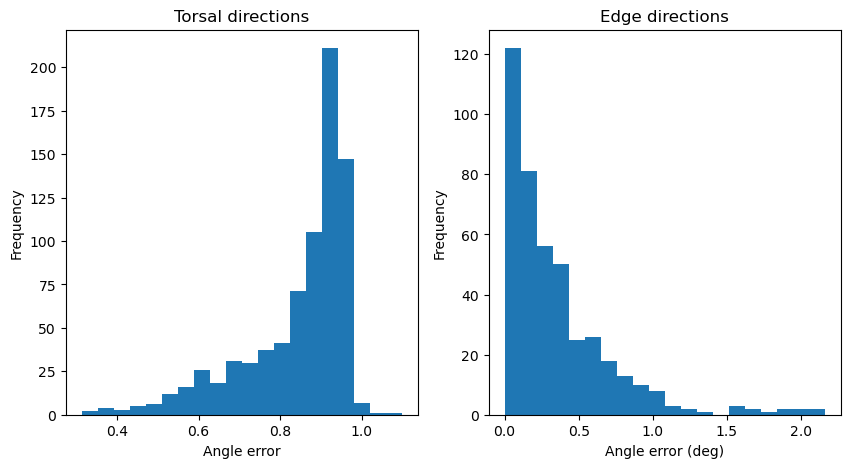

In [23]:
# Show histograms
import matplotlib.pyplot as plt

# Plot two histograms in the same figure but separated
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
# Plot histogram for torsal directions
ax1.hist(errang, bins=20)
ax1.set_xlabel("Angle error")
ax1.set_ylabel("Frequency")
ax1.set_title("Torsal directions")
# Plot histogram for edge directions
ax2.hist(err3, bins=20)
ax2.set_xlabel("Angle error (deg)")
ax2.set_ylabel("Frequency")
ax2.set_title("Edge directions")
plt.show()



### Visualize Torsal directions and errors

In [24]:
# torsal vis settings


# Init polyscope
ps.init()

ps.remove_all_structures()

# Create mesh
mesh = ps.register_surface_mesh("mesh", tv, tf)

# Add cmap mesh
#mesh.add_scalar_quantity("errang", errang, defined_on = "faces", enabled=True, cmap="coolwarm")

# color map vertices with edges error
mesh.add_scalar_quantity("err3", err3, defined_on = "vertices", enabled=True, cmap="coolwarm")

# Add torsal directions
add_cross_field(mesh, "analytical", at1, at2, 0.001, 0.008, (0.0, 0.0, 0.0))

add_cross_field(mesh, "opt", t1, t2, 0.001, 0.008, (1, 0.0, 0.0))

# Visualize directions

mesh.add_vector_quantity("e_i", e, defined_on='vertices', enabled=True, radius=0.001, length=2.0, color=(0.0, 1.0, 0.0))
mesh.add_vector_quantity("ae_i", edir, defined_on='vertices', enabled=True, radius=0.001, length=2.0, color=(0.0, 0.0, 1.0))

# # Create second mesh of envelope
# mesh2 = ps.register_surface_mesh("mesh2", tv + 3*e_i, tf)

# mesh3 = ps.register_surface_mesh("mesh3", tv + 3.01*edir, tf)

ps.show()

## Save data

In [ ]:
def export_torsal_direction(data, tv, tf, e_i):

    # Data 
    k = data

    # Create file for positions
    pos = open(os.path.join( out_path, "torsal_pos_"+str(k)+".dat"), "w")
    # Create file for torsal directions
    tdir = open(os.path.join( out_path, "torsal_dir_"+str(k)+".dat"), "w")
    # Create file to store the ids of the inner faces
    f_if = open(os.path.join( out_path, "inner_faces_"+str(k)+".dat"), "w")

    # Compute torsal directions
    barycenters, t1, t2, cos_tors = torsal_dir_vec(tv, tf, e_i)
    
    # Get inner faces
    t_mesh = Mesh()
    t_mesh.make_mesh(tv, tf)
    inner_faces = t_mesh.inner_faces()

    for ii in range(len(inner_faces)):
        i = inner_faces[ii]
        pos.write(str(barycenters[i][0]) + " " + str(barycenters[i][1]) + " " + str(barycenters[i][2]) + "\n")
        tdir.write(str(t1[i][0]) + " " + str(t1[i][1]) + " " + str(t1[i][2]) + " " + str(t2[i][0]) + " " + str(t2[i][1]) + " " + str(t2[i][2]) + "\n")
        f_if.write(str(i) + "\n")


    pos.close()
    print("Positions file created")
    tdir.close()
    print("Torsal dir files created")
    f_if.close()
    print("Inner faces file created")

def export_toral_data_testing(data, tv, tf, e_i, list_bad_faces):

    # Data
    k = data 

    # Compute torsal directions
    _, t1, t2, _ = torsal_dir_vec(tv, tf, e_i)

    # Create data frame
    df = pd.DataFrame()

    # Create a table with e_i[tf[list_bad_faces]], tv[tf[list_bad_Faces]], t1[list_bad_faces], t2[list_bad_faces]
    df["e_i"] = e_i[tf[list_bad_faces]].tolist()
    df["tv"] = tv[tf[list_bad_faces]].tolist()
    df["t1"] = t1[list_bad_faces].tolist()
    df["t2"] = t2[list_bad_faces].tolist()

    # Export df to csv
    df.to_csv(os.path.join( out_path, "bf_data_"+str(k)+".csv"), index=False)




In [ ]:
export_torsal_direction(4, tv, tf, e_i)

In [ ]:
export_toral_data_testing(4, tv, tf, e_i, np.array([847,833,806,776,770,767,733,721,688,571]))

# New Torsal Condition

In [ ]:
# Define three vertices
v = np.array([[-1,-1,-0.2], [1,0,0.1], [-0.8,0.1,0.2]])

# Define directions ei
ei = -np.array([[0,0,1], [0,0.1,0.8], [0.1,0,0.9]])
# Normalize ei
ei /= np.linalg.norm(ei, axis=1)[:, None]

# Compute the circumcircle 
c, cr, n = circle_3pts(v[0], v[1], v[2])

# Define a distance from the circumcenter to the center of a sphere
di = 2

# sphere center
sc = c + di*n

# Compute radius of the sphere
r = np.linalg.norm(v[0] - sc)

# directions vertices to center
dc = sc - v
dc /= np.linalg.norm(dc, axis=1)[:, None] # normalize

dc2 = sc - v

# Second envelope points
angles = np.sum(dc*ei, axis=1)

# ec * dc2 
dotec = np.sum(ei*dc2, axis=1)

# Compute the lambdas
l = 2*r*angles
l2 = 2*dotec

# New points
u  = v + l[:, None]*ei
u2 = v + l2[:, None]*ei

print(f"u:{u}\nu2:{u2}")

# Compute A v = u

A = u.T@np.linalg.inv(v.T)

vij  = v[1] - v[0]
vik  = v[2] - v[0]

uij = u[1] - u[0]
uik = u[2] - u[0]


t1  = 2*vij + 3*vik 
ut1 = 2*uij + 3*uik 
# Print distance u to sc
print(A@t1)
print(ut1)

# Baricenter
vc = np.mean(v, axis=0)
uc = np.mean(u, axis=0)

ec = uc - vc
ec = ec/np.linalg.norm(ec)
ec2 = np.mean(ei, axis=0)
ec2 = ec2/np.linalg.norm(ec2)

print(f"ec : {ec}\nec2: {ec2}")

# Visualization
ps.init()

ps.remove_all_structures()

# Create mesh
triangle = ps.register_surface_mesh("T1", v, np.array([[0,1,2]]))
triangle2 = ps.register_surface_mesh("T2", u, np.array([[0,1,2]]))
sphere = ps.register_point_cloud("Sphere", sc)
sphere.set_radius(r, relative=False)

# Add directions
triangle.add_vector_quantity("ei", ei, defined_on='vertices', enabled=True, radius=0.005, length=2.0, color=(0.0, 0.0, 0.0))
triangle.add_vector_quantity("t1", np.array([t1]), defined_on="faces", enabled=True, radius=0.01, length=0.5, color=(0.0, 0.0, 0.0))
triangle.add_vector_quantity("ec", np.array([ec]), defined_on="faces", enabled=True, radius=0.001, length=2.5, color=(0.8, 0.0, 0.0))
triangle.add_vector_quantity("ec2", np.array([ec2]), defined_on="faces", enabled=True, radius=0.001, length=2.5, color=(0.0, 0.0, 0.8))

triangle2.add_vector_quantity("at1", np.array([ut1]), defined_on="faces", enabled=True, radius=0.01, length=0.5, color=(0.0, 0.0, 0.0))

ps.show()




## Visualization